In [1]:
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [5]:
DECK = 4 * (list(range(2, 12)) + [10, 10, 10])

class Value(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(9, 12)
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 12)
        self.lin4 = nn.Linear(12, 1)
        

    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        x = self.lin3(x)
        x = torch.relu(x)
        return self.lin4(x)
    
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(9, 12)
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 12)
        self.lin4 = nn.Linear(12, 4) # double, split, stand, hit
        self.softmax = torch.softmax

    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = torch.relu(x)
        x = self.lin3(x)
        x = torch.relu(x)
        x = self.lin4(x)
        
        return self.softmax(x, dim = -1) 


In [14]:
def update_count(count, card):
    """Adds -1, 0, or +1 to the count given the card value"""
    if card <= 6:
        return count + 1
    elif card >= 10:
        return count - 1

    return count

def get_bet(true_count):
    return 10. + (10. * max(0, true_count))

def is_soft(c1, c2):
    return c1 == 11 or c2 == 11

def get_score(hand, c, soft):
    """returns the score and its softness given the existing hand and a new card"""
    if c != 11 and not soft:
        return False, hand + c

    if c == 11 and not soft: # if valid with 1 or 11, then is still soft (and add 11). else add 1 only
        if hand + 11 <= 21: # and by extension vaild with hand + 1
            return True, hand + 11

        return False, hand + 1

    if c != 11 and soft: # if total > 21, then subtract 10 and it's no longer soft. else, add the card and it's still soft 
        if hand + c > 21:
            return False, hand + c - 10

        return True, hand + c

    # else c == 11 and it's soft
    # my argument: we add one and it remains soft since by construction, a hand cannot be soft
    # unless it is of total at least 11
    return True, hand + 1


In [15]:
### TROUBLESHOOTING GET SCORE
#for p in range(2, 21): # isch guet
#    for c in range(2, 12):
#        s, np = get_score(p, c, False)
#        print(p, 'plus', c, 'is', np, s)

#for p in range(11, 21): # i think it's good but i don't want to check rn :)
#    for c in range(2, 12):
#        s, np = get_score(p, c, True)
#        print(p, 'plus', c, 'is', np, s)

In [16]:
def blackjack(c1, c2):
    return (c1 == 11 and c2 == 10) or (c1 == 10 and c2 == 11)

In [17]:
def g(A, epsilon):
    return (1 + epsilon) * A * (A >= 0) + (1 - epsilon) * A * (A < 0)

In [47]:
def do_game(policy, verbose = False):
    """
    does rounds of blackjack until the shoe is sufficiently low (here defined to be 20 cards) 
    """
    shoe = 8 * DECK
    random.shuffle(shoe)

    count = 0.
    winnings = 0.

    S = []
    P = []
    A = []
    R = []

    while len(shoe) > 40: # must not be less than 26 so rounding works
        if verbose:
            print('\n=== NEW ROUND ===')
            
        bet = get_bet(
            round(count / round(len(shoe) / 52))
        )
        s, p, a, reward, count = blackjack_round(shoe, policy, bet, count, verbose)

        #print(round(count / round(len(shoe) / 52)), count, len(shoe) / 52)

        S += s
        P += p
        A += a
        R += [reward for _ in s]

        winnings += reward

        #print(len(s), len(p), len(a))

    return S, P, A, R, winnings

def blackjack_round(shoe, policy, bet, count, verbose = False):
    """
    one round of blackjack
    """

    # initialize lists of states and actions to be undertaken
    states = []
    probabilities = []
    actions = []

    penalty = -500.
    bet2 = 0.
    
    # deal player cards
    c1 = shoe.pop(0)
    c2 = shoe.pop(0)

    count = update_count(count, c1)
    count = update_count(count, c2)

    player = 0.
    dealer = 0.
    
    splittable = c1 == c2

    soft, player = get_score(player, c1, False)
    soft, player = get_score(player, c2, soft)

    # deal dealer cards
    d1 = shoe.pop(0)
    d2 = shoe.pop(0)

    count = update_count(count, d1)

    soft_dealer, dealer = get_score(dealer, d1, False)

    # initiallize state vector
    # splittable | doublable | soft | score | doublable2 | soft2 | score2 | dealer upcard | true count
    state = torch.tensor(
        [
            splittable, # can split or not
            True, # can double 
            soft, # soft or not
            player, # player score 
            False, False, 0.,
            dealer,
            round(count / round(len(shoe) / 52))
        ])


    # check for blackjacks
    if blackjack(d1, d2) and not blackjack(c1, c2): # dealer, not player
        if verbose:
            print('Dealer blackjack')
            print('Payout:', -1 * bet)

        count = update_count(count, d2)
            
        return states, probabilities, actions, -1 * bet, count

    elif blackjack(d1, d2) and blackjack(c1, c2): # both
        if verbose:
            print('Double blackjack')
            print('Payout:', 0.)

        count = update_count(count, d2)
            
        return states, probabilities, actions, 0., count

    elif blackjack(c1, c2):
        if verbose:
            print('Blackjack!')
            print('Payout:', 1.5 * bet)

        count = update_count(count, d2)
        
        return states, probabilities, actions, 1.5 * bet, count

    # print what's up
    if verbose:
        print('Player:', 'soft' if soft else '', player, '| Dealer:', d1, '| Running Count:', count)


    # player gets to 21 by doing actions
    while state[3] < 21: 

        states.append(state)
        
        # get action - 0 stand, 1 hit, 2 double, 3 split
        probs = policy(state).detach()
        action = torch.distributions.Categorical(probs = probs).sample().item()

        probabilities.append(probs)
        actions.append(action)

        if verbose:
            print('Action:', ['stand', 'hit', 'double', 'split'][action])

        if action == 0:
            break

        if action == 1:
            c = shoe.pop(0)
            count = update_count(count, c)
            
            state[2], state[3] = get_score(state[3], c, state[2])
            state[8] = round(count / round(len(shoe) / 52))

            # update so no splits or doubles
            state[0] = False
            state[1] = False

            if verbose:
                print('Player:', 'soft' if state[2] else '', state[3].item())

        if action == 2:
            if not state[1]: # if we doubled when we were not permitted
                if verbose:
                    print('Invalid!')

                return states, probabilities, actions, penalty, count

            # else it's just the same as above
            c = shoe.pop(0)
            count = update_count(count, c)
            
            state[2], state[3] = get_score(state[3], c, state[2])
            state[8] = round(count / round(len(shoe) / 52))

            # update so no splits or doubles
            state[0] = False
            state[1] = False

            # double the bet
            bet *= 2

            if verbose:
                print('Player:', 'soft' if state[2] else '', state[3].item())

            break

        if action == 3:
            if not state[0]:
                if verbose:
                    print('Invalid!')

                return states, probabilities, actions, penalty, count

            # can no longer split
            state[0] = False

            # redistribute cards
            if state[2] and state[3] == 12: # if double aces
                state[3] = 11.
                state[6] = 11.

                state[2] = True
                state[5] = True

            else: # otherwise it's simplly half the score
                state[3] /= 2
                state[6] = state[3]

                state[2] = False
                state[5] = False

            # add two new cards
            c = shoe.pop(0)
            count = update_count(count, c)
            state[2], state[3] = get_score(state[3], c, state[2])

            c = shoe.pop(0)
            count = update_count(count, c)
            state[5], state[6] = get_score(state[6], c, state[5])

            state[8] = round(count / round(len(shoe) / 52))

            # update doubleables
            state[1] = True
            state[4] = True

            # instantiate the second bet
            bet2 = 1. * bet

            if verbose:
                print('Player:', 'soft' if state[2] else '', state[3].item(), '| Player 2:', 'soft' if state[5] else '', state[6].item())


    # see if the second hand must be processed
    if state[6] != 0:
        while state[6] < 21:

            states.append(state)
            
            probs = policy(state).detach()
            action = torch.distributions.Categorical(probs = probs).sample().item()

            probabilities.append(probs)
            actions.append(action)
    
            if verbose:
                print('Action 2:', ['stand', 'hit', 'double', 'split'][action])
    
            if action == 0:
                break
    
            if action == 1:
                c = shoe.pop(0)
                count = update_count(count, c)
                
                state[5], state[6] = get_score(state[6], c, state[5])
                state[8] = round(count / round(len(shoe) / 52))
    
                # update so no doubles
                state[4] = False
    
                if verbose:
                    print('Player 2:', 'soft' if state[5] else '', state[6].item())
    
            if action == 2:
                if not state[4]: # if we doubled when we were not permitted
                    if verbose:
                        print('Invalid!')
    
                    return states, probabilities, actions, penalty, count
    
                # else it's just the same as above
                c = shoe.pop(0)
                count = update_count(count, c)
                
                state[5], state[6] = get_score(state[6], c, state[5])
                state[8] = round(count / round(len(shoe) / 52))
    
                # update so no doubles
                state[4] = False
                bet2 *= 2
    
                if verbose:
                    print('Player 2:', 'soft' if state[5] else '', state[6].item())
    
                break
    
            if action == 3:
                if verbose:
                    print('Invalid!')
    
                return states, probabilities, actions, penalty, count


    #states.append(state)


    # we may not have to process the dealer hand
    # (1) hand 1 busts and hand 2 doesn't exist ; (2) both hands exist, and both bust
    if state[3] > 21 and state[6] == 0:
        if verbose:
            print('Bust. Payout:', -1 * bet)

        soft_dealer, dealer = get_score(dealer, d2, soft_dealer)
        return states, probabilities, actions, -1 * bet, count

    if state[3] > 21 and state[6] > 21:
        if verbose:
            print('Both hands bust. Payout:', -1 * (bet + bet2))

        soft_dealer, dealer = get_score(dealer, d2, soft_dealer)
        return states, probabilities, actions, -1 * (bet + bet2), count

    
    # otherwise, we must process the dealer hand
    soft_dealer, dealer = get_score(dealer, d2, soft_dealer)
    count = update_count(count, d2)

    while dealer < 17:
        d = shoe.pop(0)
        count = update_count(count, d)
        
        soft_dealer, dealer = get_score(dealer, d, soft_dealer)

    if verbose:
        print('Dealer:', dealer)

    
    # check for dealer bust
    if dealer > 21:
        if verbose:
            print('Player victory. Payout:', (2 * (state[3].item() <= 21) - 1) * bet + (2 * (state[6].item() <= 21) - 1) * bet2)

        return states, probabilities, actions, ((2 * (state[3].item() <= 21) - 1) * bet) + ((2 * (state[6].item() <= 21) - 1) * bet2), count


    # do comparisons
    # only first hand ~OR~ first hand and second hand bust
    if state[3] <= 21 and (state[6] == 0 or state[6] > 21): # then it's win loss or tie (already accountued for bust case)
        if state[3] > dealer:
            if verbose:
                print('Payout:', bet - bet2)

            return states, probabilities, actions, bet - bet2, count

        elif state[3] == dealer:
            if verbose:
                print('Payout:', 0. - bet2)

            return states, probabilities, actions, 0. - bet2, count

        else: 
            if verbose:
                print('Payout:', -1 * bet - bet2)

            return states, probabilities, actions, -1 * bet - bet2, count

    # first hand bust, second hand valid
    if state[3] > 21 and state[6] <= 21:
        if state[6] > dealer:
            if verbose:
                print('Payout:', bet2 - bet)

            return states, probabilities, actions, bet - bet2, count

        elif state[6] == dealer:
            if verbose:
                print('Payout:', 0. - bet)

            return states, probabilities, actions, 0. - bet, count

        else: 
            if verbose:
                print('Payout:', -1 * bet2 - bet)

            return states, probabilities, actions, -1 * bet2 - bet, count

    # both hands valid
    if state[3] == dealer:
        if state[6] == dealer:
            if verbose:
                print('Payout:', 0.)
                
            return states, probabilities, actions, 0., count
        # else we won or lost
        if verbose:
            print('Payout:', bet2 * (2 * (state[6] > dealer).item() - 1))

        return states, probabilities, actions, bet2 * (2 * (state[6] > dealer).item() - 1), count

    elif state[6] == dealer:
        # then just account for first hand, already accounted for equality case
        if verbose:
            print('Payout:', bet * (2 * (state[3] > dealer) - 1).item())
            
        return states, probabilities, actions, bet * (2 * (state[3] > dealer) - 1).item(), count

    # else both are not ties and eligible for consideration
    if verbose:
        print('Payout:', bet * (2 * (state[3] > dealer) - 1).item() + (bet2 * (2 * (state[6] > dealer) - 1).item()))
    return states, probabilities, actions, bet * (2 * (state[3] > dealer) - 1).item() + (bet2 * (2 * (state[6] > dealer) - 1)).item(), count


In [48]:
#policy = Policy()

#do_game(policy, verbose = True)

In [79]:
def train(policy, value, games = 10, epochs = 20):

    optimizer_value = Adam(value.parameters(), lr = 1e-3)
    optimizer_policy = Adam(policy.parameters(), lr = 1e-3)

    batch_size = 50
    W = []

    for epoch in range(epochs):

        S = []
        P = []
        A = []
        R = []

        winnings = 0.

        # generate games
        for _ in range(games):

            s, p, a, r, w = do_game(policy, verbose = False)

            S += s
            P += p
            A += a
            R += r
            
            winnings += w

        # tensorize things for easy computation + advantage estimation        
        S = torch.stack(S)
        P = torch.stack(P)
        Ai = torch.tensor(A)
        A = Ai.reshape(-1, 1)
        R = torch.tensor(R).reshape(-1, 1)

        V = R - value(S).detach()

        dataset = DataLoader(TensorDataset(S, P, Ai, A, R, V), batch_size = batch_size)
        
        # policy training loop        
        for j in range(200):
            loss = 0.

            for s, p, ai, a, r, v in dataset:
                N = s.shape[0]

                optimizer_policy.zero_grad()
                probs = policy(s)
                
                first_argument = v * probs[torch.arange(N), ai].reshape(-1, 1) / p[torch.arange(N), ai].reshape(-1, 1)
                second_argument = g(v, 0.2)
                
                li = -1 * torch.sum(torch.min(first_argument, second_argument)) # multiply by negative 1 so it goes up
                
                li.backward()
                optimizer_policy.step()

                loss += li.detach() 

            #print(loss)


        # value training loop
        for _ in range(200):
            loss = 0.

            for s, p, ai, a, r, v in dataset:
                optimizer_value.zero_grad()
                
                val = value(s)
                li = torch.mean((val - r)**2)
                
                li.backward()
                optimizer_value.step()

                loss += li.detach()

            #print(loss)


        # print the important things
        print('=== Epoch', epoch, '| Winnings:', winnings, '===')
        W.append(winnings)

        #if epoch % 10 == 0:
        #    do_game(policy, verbose = True)

    return W

        
  

In [80]:
value = Value()
policy = Policy()

W = train(policy, value)

=== Epoch 0 | Winnings: -120670.0 ===
=== Epoch 1 | Winnings: -96150.0 ===
=== Epoch 2 | Winnings: -25430.0 ===
=== Epoch 3 | Winnings: -11215.0 ===
=== Epoch 4 | Winnings: -4155.0 ===
=== Epoch 5 | Winnings: -7165.0 ===
=== Epoch 6 | Winnings: -5425.0 ===
=== Epoch 7 | Winnings: -4745.0 ===
=== Epoch 8 | Winnings: -4980.0 ===
=== Epoch 9 | Winnings: -5020.0 ===
=== Epoch 10 | Winnings: -3970.0 ===
=== Epoch 11 | Winnings: -5705.0 ===
=== Epoch 12 | Winnings: -19645.0 ===
=== Epoch 13 | Winnings: -7765.0 ===
=== Epoch 14 | Winnings: -2640.0 ===
=== Epoch 15 | Winnings: -3165.0 ===
=== Epoch 16 | Winnings: -5415.0 ===
=== Epoch 17 | Winnings: -3240.0 ===
=== Epoch 18 | Winnings: -4455.0 ===
=== Epoch 19 | Winnings: -3515.0 ===


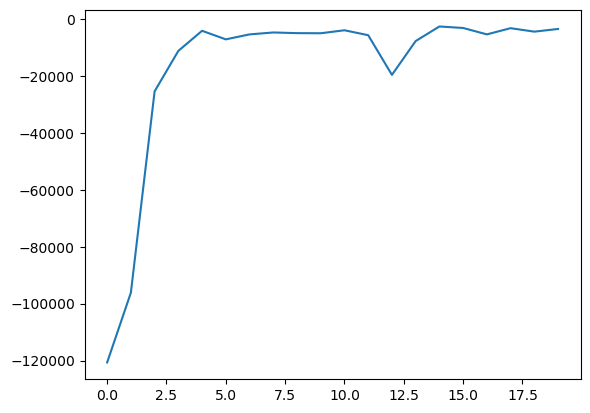

In [81]:
plt.plot(W)

In [82]:
do_game(policy, verbose = True)


=== NEW ROUND ===
Player:  20.0 | Dealer: 7 | Running Count: -2.0
Action: stand
Dealer: 17.0
Payout: 10.0

=== NEW ROUND ===
Player:  20.0 | Dealer: 3 | Running Count: -4.0
Action: hit
Player:  30.0
Bust. Payout: -10.0

=== NEW ROUND ===
Player: soft 18.0 | Dealer: 10 | Running Count: -7.0
Action: stand
Dealer: 20.0
Payout: -10.0

=== NEW ROUND ===
Player:  17.0 | Dealer: 10 | Running Count: -10.0
Action: stand
Dealer: 20.0
Payout: -10.0

=== NEW ROUND ===
Player:  19.0 | Dealer: 4 | Running Count: -11.0
Action: stand
Dealer: 17.0
Payout: 10.0

=== NEW ROUND ===
Player:  7.0 | Dealer: 10 | Running Count: -10.0
Action: stand
Dealer: 20.0
Payout: -10.0

=== NEW ROUND ===
Player:  18.0 | Dealer: 7 | Running Count: -12.0
Action: stand
Dealer: 17.0
Payout: 10.0

=== NEW ROUND ===
Player:  11.0 | Dealer: 6 | Running Count: -10.0
Action: stand
Dealer: 18.0
Payout: -10.0

=== NEW ROUND ===
Player: soft 15.0 | Dealer: 6 | Running Count: -8.0
Action: stand
Dealer: 18.0
Payout: -10.0

=== NEW RO

([tensor([ 1.,  1.,  0., 20.,  0.,  0.,  0.,  7.,  0.]),
  tensor([ 0.,  0.,  0., 30.,  0.,  0.,  0.,  3., -1.]),
  tensor([ 0.,  1.,  1., 18.,  0.,  0.,  0., 10., -1.]),
  tensor([ 0.,  1.,  0., 17.,  0.,  0.,  0., 10., -1.]),
  tensor([ 0.,  1.,  0., 19.,  0.,  0.,  0.,  4., -1.]),
  tensor([ 0.,  1.,  0.,  7.,  0.,  0.,  0., 10., -1.]),
  tensor([ 0.,  1.,  0., 18.,  0.,  0.,  0.,  7., -2.]),
  tensor([ 0.,  1.,  0., 11.,  0.,  0.,  0.,  6., -1.]),
  tensor([ 0.,  1.,  1., 15.,  0.,  0.,  0.,  6., -1.]),
  tensor([ 1.,  1.,  0., 16.,  0.,  0.,  0., 10., -1.]),
  tensor([ 1.,  1.,  0.,  4.,  0.,  0.,  0.,  8., -1.]),
  tensor([ 0.,  1.,  0., 17.,  0.,  0.,  0., 10., -1.]),
  tensor([ 0.,  1.,  0., 15.,  0.,  0.,  0.,  2., -1.]),
  tensor([ 0.,  1.,  0., 16.,  0.,  0.,  0., 10.,  0.]),
  tensor([ 0.,  1.,  0., 14.,  0.,  0.,  0., 10.,  0.]),
  tensor([ 0.,  1.,  1., 14.,  0.,  0.,  0., 10., -1.]),
  tensor([ 0.,  1.,  0., 18.,  0.,  0.,  0., 10., -1.]),
  tensor([ 1.,  1.,  0.,  6.,  

## some obvious test cases to see if the model is learning
### Hand: hard 20 on 6 with P true and D irrelevant
### Policy: should stand
### Value: should be basically 10 (if doublable, since this indicates 20 was dealt initially)

In [83]:
# splittable | doublable | soft | score | doublable2 | soft2 | score2 | dealer upcard
test1 = torch.tensor([1., 0., 0., 20., 0., 0., 0., 6., 0.]).reshape(1, -1)

with torch.no_grad():
    print('Test 1')
    print('Policy:', policy(test1)) # get action - 0 stand, 1 hit, 2 double, 3 split

test2 = torch.tensor([1., 1., 0., 20., 0., 0., 0., 6., 0.]).reshape(1, -1)

with torch.no_grad():
    print('')
    print('Test 2')
    print('Policy:', policy(test2))
    print('Value:', value(test2))

Test 1
Policy: tensor([[9.3406e-01, 6.5943e-02, 8.9530e-12, 3.2010e-11]])

Test 2
Policy: tensor([[7.1265e-01, 2.8735e-01, 1.6176e-12, 2.3479e-11]])
Value: tensor([[10.0854]])


### Hand: hard 11 on 8 with P false and D true
### Policy: should double

In [84]:
test3 = torch.tensor([0., 1., 0., 11., 0., 0., 0., 8., 0.]).reshape(1, -1)

with torch.no_grad():
    print('Test 3')
    print('Policy:', policy(test3)) # get action - 0 stand, 1 hit, 2 double, 3 split

Test 3
Policy: tensor([[9.9982e-01, 1.7942e-04, 8.3908e-14, 6.1079e-12]])


### Hand: soft 19 on 4 with P true and D true
### Policy: should stand

In [85]:
test4 = torch.tensor([1., 1., 1., 19., 0., 0., 0., 4., 0.]).reshape(1, -1)

with torch.no_grad():
    print('Test 4')
    print('Policy:', policy(test4)) # get action - 0 stand, 1 hit, 2 double, 3 split

Test 4
Policy: tensor([[3.9582e-05, 9.9996e-01, 1.7969e-17, 8.7591e-15]])


### Hand: hard 16 on 3 with P true and D true
### Policy: should split (since 16 is a crappy hand)

In [86]:
test5 = torch.tensor([1., 1., 1., 16., 0., 0., 0., 3., 0.]).reshape(1, -1)

with torch.no_grad():
    print('Test 5')
    print('Policy:', policy(test5)) # get action - 0 stand, 1 hit, 2 double, 3 split

Test 5
Policy: tensor([[4.0370e-06, 1.0000e+00, 3.0634e-18, 3.5581e-15]])
